In [11]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [12]:
# Modeli yükle
model = joblib.load("isolation_forest_model.pkl")

In [13]:
# Test veri setini yükle
df_test = pd.read_csv(r"C:\Users\lenovo\Desktop\verianalizi\users_errors.csv")  # Test veri setinizin yolu

In [14]:
df_test.replace("Invalid Input", np.nan, inplace=True)
df_test.dropna(inplace=True)

In [27]:
# Kategorik verileri sayısal hale getir
categorical_columns = ["interaction_type", "interaction_details", "device_id", "ip_address", "location"]
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    # Yeni veride olmayan etiketlerle karşılaşıldığında 'ignore' parametresi sayesinde hata almazsınız.
    df_test[col] = le.fit_transform(df_test[col].astype(str))  # Veriyi sayısala çevir
    label_encoders[col] = le  # LabelEncoder'ı sakla



In [29]:
# Kullanılmayacak sütunları kaldır
X_test = df_test.drop(columns=["id", "user_id", "interaction_time"])


In [30]:
# Anomali tahminlerini yap
df_test["is_anomaly"] = model.predict(X_test)
df_test["is_anomaly"] = df_test["is_anomaly"].apply(lambda x: 1 if x == -1 else 0)


In [38]:
y_true = df_test["is_anomaly"]  # Gerçek etiketleri al
y_pred = model.predict(X_test)  # Modelin tahminlerini al

# Isolation Forest'ın çıktısını [0,1] aralığına çevirelim (-1 -> 1 (anomali), 1 -> 0 (normal))
y_pred = [1 if pred == -1 else 0 for pred in y_pred]

# Confusion matrix ve classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Confusion Matrix:
 [[737   0]
 [  0  82]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       737
           1       1.00      1.00      1.00        82

    accuracy                           1.00       819
   macro avg       1.00      1.00      1.00       819
weighted avg       1.00      1.00      1.00       819



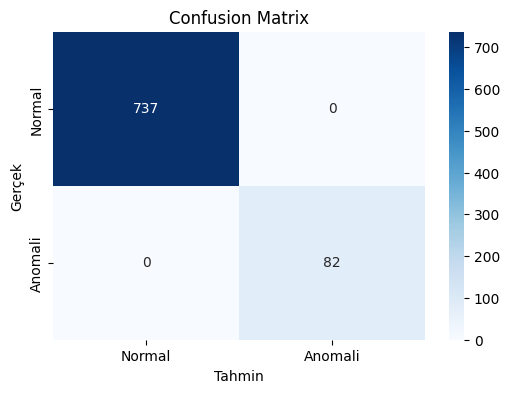

In [39]:
# Confusion matrix görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomali"], yticklabels=["Normal", "Anomali"])
plt.title("Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()

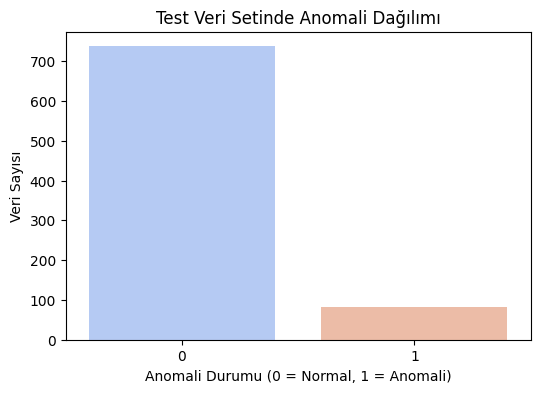

In [40]:
# Anomali tahminlerinin görselleştirilmesi
plt.figure(figsize=(6, 4))
sns.countplot(data=df_test, x="is_anomaly", hue="is_anomaly", palette="coolwarm", legend=False)
plt.title("Test Veri Setinde Anomali Dağılımı")
plt.xlabel("Anomali Durumu (0 = Normal, 1 = Anomali)")
plt.ylabel("Veri Sayısı")
plt.show()

In [43]:
# Gerçek zamanlı tahmin fonksiyonu
def real_time_prediction(new_data):
    """
    Bu fonksiyon, gelen yeni veriye göre modelin tahmin yapmasını sağlar.
    :param new_data: Yeni veri, bir dictionary veya pandas DataFrame olabilir.
    :return: Modelin tahmini (0 = Normal, 1 = Anomali)
    """
    # Yeni veriyi DataFrame'e çevir
    new_data_df = pd.DataFrame([new_data])

    # Kategorik verileri sayısal hale getir
    for col in categorical_columns:
        if col in new_data_df.columns:
            new_data_df[col] = label_encoders[col].transform(new_data_df[col].astype(str))

    # Kullanılmayan sütunları kaldır
    new_data_df = new_data_df.drop(columns=["id", "user_id", "interaction_time"], errors='ignore')

    # Model tahmini yap
    prediction = model.predict(new_data_df)
    prediction = 1 if prediction == -1 else 0  # Model tahminini 0 veya 1'e çevir

    return prediction  # Girinti sorunu çözüldü


In [52]:
import pandas as pd

# Örnek eğitim veri seti
data = {
    "location": ["İstanbul", "Ankara", "İzmir"],
    "ip_address": ["10.0.0.1", "10.0.0.2", "10.0.0.3", "10.0.0.4", "10.0.0.5"],
    "device_id": ["DEV1234", "DEV5678", "DEV9999", "DEV1111", "DEV2222"]
}
df = pd.DataFrame(data)

# Gerçek zamanlı bir veri örneği ile tahmin yapalım
new_interaction = {
    "interaction_type": "Permission Denied",
    "interaction_details": "Incorrect password",
    "device_id": "DEV9999",
    "ip_address": "10.0.0.2",
    "location": "İstanbul"
}

# Eğitim verisindeki benzersiz değerler
known_locations = df["location"].unique()
known_ips = df["ip_address"].unique()
known_devices = df["device_id"].unique()



# Gerçek zamanlı veriyi kontrol et
def check_for_anomaly(new_data, known_locations, known_ips, known_devices):
    anomalies = []

    # Lokasyon kontrolü
    if new_data["location"] not in known_locations:
        anomalies.append("location")

    # IP adresi kontrolü
    if new_data["ip_address"] not in known_ips:
        anomalies.append("ip_address")

    # Cihaz ID kontrolü
    if new_data["device_id"] not in known_devices:
        anomalies.append("device_id")
    
    # Eğer anomali varsa, 1 döndür
    if anomalies:
        print(f"Anomaliler: {', '.join(anomalies)}")
        return 1  # Anomali (1)
    else:
        return 0  # Normal (0)

# Gerçek zamanlı veriyi kontrol et ve tahmini yazdır
prediction = check_for_anomaly(new_interaction, known_locations, known_ips, known_devices)
print(f"Gerçek zamanlı tahmin: {prediction} (0 = Normal, 1 = Anomali)")

Gerçek zamanlı tahmin: 0 (0 = Normal, 1 = Anomali)
